# US Hospital Cost vs Quality & Regional Disparities (SQL → Python → Tableau)

## Goal
Analyze whether **higher procedure costs** are associated with **better quality ratings** and identify **state level disparities** in cost and performance.

## Tools
- **SQL (MySQL):** schema design, data cleaning, joins (state mapping), exporting analysis ready table
- **Python:** EDA, correlations, scatter + boxplots, state level aggregation, choropleth
- **Tableau:** dashboard for interactive exploration (state, procedure, cost, quality)


## Key Questions
1. Which states have higher/lower **procedure cost availability**?
2. Do procedure **costs correlate with quality** ratings?
3. For pneumonia: do higher costs consistently mean better quality?
4. Are there clear **regional patterns** in average cost (by state)?


## Data Notes & Assumptions
- Procedure “Quality” is treated as an **ordinal score** (e.g., 1=Worse, 2=Average, 3=Better).
- Nulls in procedure fields often mean **not reported / not available**, not “zero”.
- Analysis focuses on **comparisons within the same procedure** (e.g., pneumonia cost vs pneumonia quality).


In [ ]:
!pip install mysql-connector-python

In [2]:
import pandas as pd
import numpy as np
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [4]:
conn = mysql.connector.connect(
                host = "127.0.0.1",
                user = "root",
                password = "Akku_0707",
                database = "US_Hospitals"
)

query = "SELECT * FROM hospitals;"
hospitals = pd.read_sql(query, conn)
conn.close()

hospitals.head()

/var/folders/4z/4xhnb8s949l2_401d3hsw1wh0000gn/T/ipykernel_21220/2401197592.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  hospitals = pd.read_sql(query, conn)


,Facility_Name,Facility_City,Facility_State,State_FullName,Facility_Type,Rating_Overall,Rating_Mortality,Rating_Safety,Rating_Readmission,Rating_Experience,...,Procedure_HeartAttack_Value,Procedure_HeartFailure_Cost,Procedure_HeartFailure_Quality,Procedure_HeartFailure_Value,Procedure_Pneumonia_Cost,Procedure_Pneumonia_Quality,Procedure_Pneumonia_Value,Procedure_HipKnee_Cost,Procedure_HipKnee_Quality,Procedure_HipKnee_Value
0,Southeast Alabama Medical Center,Dothan,AL,Alabama,Government,2.0,1.0,3.0,1.0,1.0,...,2.0,17041.0,2.0,2.0,18281.0,2.0,2.0,25812.0,2.0,1.0
1,Marshall Medical Center South,Boaz,AL,Alabama,Government,1.0,1.0,1.0,1.0,2.0,...,2.0,15819.0,1.0,2.0,15614.0,1.0,3.0,22747.0,2.0,2.0
2,Eliza Coffee Memorial Hospital,Florence,AL,Alabama,Government,3.0,1.0,3.0,3.0,1.0,...,2.0,16334.0,2.0,2.0,17371.0,2.0,2.0,24491.0,2.0,1.0
3,Mizell Memorial Hospital,Opp,AL,Alabama,Private,1.0,2.0,2.0,1.0,1.0,...,NaN,14541.0,2.0,3.0,15226.0,1.0,3.0,23472.0,2.0,2.0
4,Crenshaw Community Hospital,Luverne,AL,Alabama,Proprietary,4.0,2.0,NaN,3.0,NaN,...,NaN,13767.0,2.0,3.0,14341.0,2.0,3.0,NaN,NaN,NaN


In [6]:
print("Rows:", hospitals.shape[0])
print("Columns:", hospitals.shape[1])

Rows: 4772
Columns: 25


In [10]:
hospitals.info()
hospitals.isna().sum().sort_values(ascending=False).head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4772 entries, 0 to 4771
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Facility_Name                   4772 non-null   object 
 1   Facility_City                   4772 non-null   object 
 2   Facility_State                  4772 non-null   object 
 3   State_FullName                  4772 non-null   object 
 4   Facility_Type                   4772 non-null   object 
 5   Rating_Overall                  3715 non-null   float64
 6   Rating_Mortality                3397 non-null   float64
 7   Rating_Safety                   2630 non-null   float64
 8   Rating_Readmission              3872 non-null   float64
 9   Rating_Experience               3432 non-null   float64
 10  Rating_Effectiveness            3834 non-null   float64
 11  Rating_Timeliness               3759 non-null   float64
 12  Rating_Imaging                  30

Procedure_HeartAttack_Value      2506
Procedure_HeartAttack_Quality    2506
Procedure_HeartAttack_Cost       2504
Rating_Safety                    2142
Procedure_HipKnee_Value          2045
Procedure_HipKnee_Quality        2045
Procedure_HipKnee_Cost           2045
Rating_Imaging                   1718
Rating_Mortality                 1375
Rating_Experience                1340
dtype: int64

In [9]:
# checking the summary statics of all the column (numerical + categorical)
hospitals.describe(include = 'all')

,Facility_Name,Facility_City,Facility_State,State_FullName,Facility_Type,Rating_Overall,Rating_Mortality,Rating_Safety,Rating_Readmission,Rating_Experience,...,Procedure_HeartAttack_Value,Procedure_HeartFailure_Cost,Procedure_HeartFailure_Quality,Procedure_HeartFailure_Value,Procedure_Pneumonia_Cost,Procedure_Pneumonia_Quality,Procedure_Pneumonia_Value,Procedure_HipKnee_Cost,Procedure_HipKnee_Quality,Procedure_HipKnee_Value
count,4772,4772,4772,4772,4772,3715.000000,3397.000000,2630.000000,3872.000000,3432.000000,...,2266.000000,3479.000000,3472.000000,3472.000000,4015.000000,4013.000000,4013.000000,2727.000000,2727.000000,2727.000000
unique,4589,2929,56,56,5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Memorial Hospital,Chicago,TX,Texas,Private,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,15,29,403,403,2078,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,3.083984,2.010598,2.107985,2.039256,2.023310,...,1.996911,16664.326531,2.017569,1.964862,17383.219427,1.995016,2.015201,21875.723872,2.008801,2.132013
std,NaN,NaN,NaN,NaN,NaN,1.057043,0.464784,0.884190,0.859255,0.814138,...,0.415472,1396.046509,0.308306,0.521978,1948.929721,0.337835,0.645962,2551.684534,0.202505,0.777168
min,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,11716.000000,1.000000,1.000000,10816.000000,1.000000,1.000000,15517.000000,1.000000,1.000000
25%,NaN,NaN,NaN,NaN,NaN,2.000000,2.000000,1.000000,1.000000,1.000000,...,2.000000,15698.000000,2.000000,2.000000,16189.000000,2.000000,2.000000,20070.000000,2.000000,2.000000
50%,NaN,NaN,NaN,NaN,NaN,3.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,16576.000000,2.000000,2.000000,17327.000000,2.000000,2.000000,21613.000000,2.000000,2.000000
75%,NaN,NaN,NaN,NaN,NaN,4.000000,2.000000,3.000000,3.000000,3.000000,...,2.000000,17529.000000,2.000000,2.000000,18479.500000,2.000000,2.000000,23318.500000,2.000000,3.000000


In [58]:
# Top 10 states by number of hospitals in the dataset
top_states = (hospitals['State_FullName'].value_counts().head(10).index)

# Filter rows to only those states (needed because boxplot needs the actual rows)
filtered_states = hospitals[hospitals['State_FullName'].isin(top_states)]

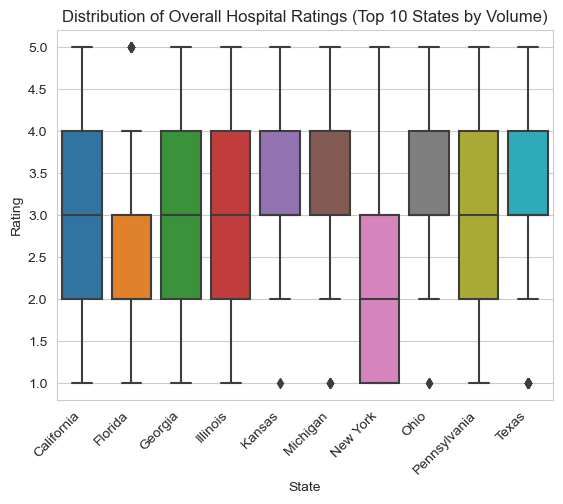

In [34]:
# Box plot for the over all rating for top 10 states

sns.boxplot(x="State_FullName", y = "Rating_Overall", data = filtered_states)
plt.title("Distribution of Overall Hospital Ratings (Top 10 States by Volume)")
plt.xlabel("State")
plt.ylabel("Rating")
plt.xticks(rotation= 45, ha = "right")
plt.show()

In [22]:
hospitals.columns

Index(['Facility_Name', 'Facility_City', 'Facility_State', 'State_FullName',
       'Facility_Type', 'Rating_Overall', 'Rating_Mortality', 'Rating_Safety',
       'Rating_Readmission', 'Rating_Experience', 'Rating_Effectiveness',
       'Rating_Timeliness', 'Rating_Imaging', 'Procedure_HeartAttack_Cost',
       'Procedure_HeartAttack_Quality', 'Procedure_HeartAttack_Value',
       'Procedure_HeartFailure_Cost', 'Procedure_HeartFailure_Quality',
       'Procedure_HeartFailure_Value', 'Procedure_Pneumonia_Cost',
       'Procedure_Pneumonia_Quality', 'Procedure_Pneumonia_Value',
       'Procedure_HipKnee_Cost', 'Procedure_HipKnee_Quality',
       'Procedure_HipKnee_Value'],
      dtype='object')

In [53]:
pneumonia_df = hospitals[['Procedure_Pneumonia_Cost', 'Procedure_Pneumonia_Quality']].dropna()

## Pneumonia: Cost vs Quality (Hospital-level)
We test if hospitals with higher pneumonia treatment costs consistently deliver better quality outcomes.


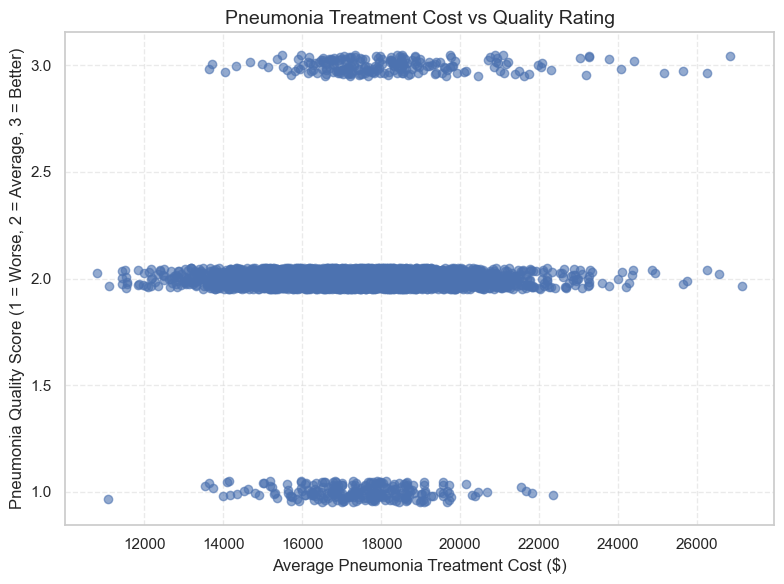

In [54]:
plt.figure(figsize=(8, 6))

plt.scatter(
    pneumonia_df['Procedure_Pneumonia_Cost'],
    pneumonia_df['Procedure_Pneumonia_Quality'] + np.random.uniform(-0.05, 0.05, size=len(pneumonia_df)),
    alpha=0.6
)

plt.title('Pneumonia Treatment Cost vs Quality Rating', fontsize=14)
plt.xlabel('Average Pneumonia Treatment Cost ($)')
plt.ylabel('Pneumonia Quality Score (1 = Worse, 2 = Average, 3 = Better)')

plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## Correlation Heatmap: Procedure Cost vs Quality
This summarizes how procedure costs relate to procedure quality scores across hospitals.


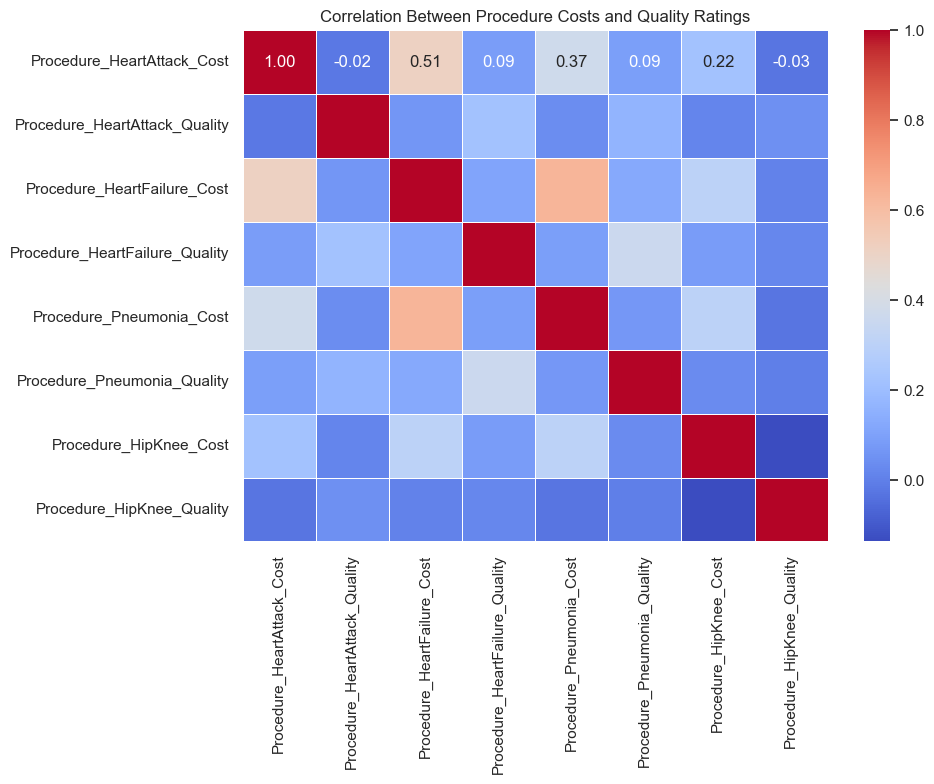

In [55]:
numeric_cols = ['Procedure_HeartAttack_Cost',
       'Procedure_HeartAttack_Quality', 
       'Procedure_HeartFailure_Cost', 
       'Procedure_HeartFailure_Quality',
       'Procedure_Pneumonia_Cost',
       'Procedure_Pneumonia_Quality', 
       'Procedure_HipKnee_Cost', 
       'Procedure_HipKnee_Quality']

corr = hospitals[numeric_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5
)

plt.title("Correlation Between Procedure Costs and Quality Ratings")
plt.tight_layout()
plt.show()


## Key Findings (So Far)
- Pneumonia cost shows **significant overlap** across all quality levels → higher cost does not consistently mean better quality.
- Cost variation at similar quality levels suggests **inefficiencies** and opportunities for cost optimization.
- State-level averages show noticeable **regional disparities** in costs and hospital volumes.
